In [1]:
import pickle
import sys
import os
import numpy as np

In [2]:
from tqdm.auto import tqdm
import sklearn.linear_model
from scipy.stats import pearsonr
from joblib import Parallel, delayed

/opt/homebrew/Caskroom/miniforge/base/envs/lcc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1: Sentence decoding

## Importing different Language Models

In [3]:
# import a word2vec model from gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
w2v = gensim.downloader.load('fasttext-wiki-news-subwords-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Load the data

In [4]:
# Download and extract the data and learn_decoder.py
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
# !mkdir data
# !wget --header="Host: drive.usercontent.google.com" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,he;q=0.8" --header="Cookie: HSID=AHJfxja1o67aaDDKP; SSID=AcFaYUEeiC88MwrF9; APISID=-FXvHmBvJ828Jrpq/AaIp_RI6gKwBAA-zy; SAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-1PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-3PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; S=billing-ui-v3=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:billing-ui-v3-efe=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:maestro=dsv3G-owxPD6uTATLH0lBQZNadhFo6ZKJiuB9usoQVU; __Secure-BUCKET=CPgG; SID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx_uObP_F4bCqI8I561ccGMwACgYKAWESARQSFQHGX2Mi5DnhBiJ2gjjbMSP0XJbU5BoVAUF8yKrlBjWMdNOfGnmA7TZzmbWD0076; __Secure-1PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx2BFINS8lXhFUyAFwuvl8CQACgYKAW4SARQSFQHGX2MiWd6bHkI0JN89-1dFZUbS2hoVAUF8yKpc-H3AD8N6tj-dmFG21SeE0076; __Secure-3PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyxJl_TGsCsjeiVN72q3lSCWQACgYKASASARQSFQHGX2MiULluXa7aABDwxgCWjB6IyhoVAUF8yKoy_HHYLCqIFMwNjx-GwYWe0076; __Secure-ENID=20.SE=jyM_w2hA8DW6FvPOh9wudde93a0A9P41Epzo098LV_LyU79-VVcJ9K-vNLrhCLuVzi69CyV4RxlSls8AAT9J8odwIXi_ISVn8Z1U1DH52BC3YiwOwO9LKUsBesCbGx2D6u1XwZ5GIP_PZMo1tkLLJq2VCtcxRP9OtC_QgHNbAD4eyc1TTu1C8XbZLFTOIgb0k9IfM2bMBXeha6t3sJysARZWpDIzs3I8wWZ5JtABB253grtjQyCnxyy9MUgTcYAVaoEGwgVHV4V4lSY6gydFkO2gYxl7JqYloqCq74HahGK54TBlsGZIOTM_KvFAsIidcrPaVOBpH6IGQTPChxy3Tr-GLK7VpBiQ8JW7V0xC8XTN1crEaaZnGFQ6MrjDv8f3hCY0Kg; AEC=AQTF6HwEtUB747fVHMzvOWJV9pmRoGs8Ix8FJ1HTrxbE9NY1dtyro2AvNQ; NID=515=Wdt0NWZqVSh3TtdIfjXCGTCCkj7jaJjt-lkOL3hLD_hPSSMyGxKkVthECwGGFbbxmvfM2iKZ1SkPGDVgLwjghAOrV9Ya7iEJJ0eSXZSfszc0WxRXm3Jy6LxqPEZLmY8v3AIkMX-o8KE5ZRXGEzgv_s9pfgS8bmeiIGT13Iiyw9tPzRZDChGijNbZ0Mp1oF-4YKikOZCyo8Km9wXOgLAC9dbeIqAlTdER97cQ7B5GajyRLH_bFrg0lCVN4tyZEycjihHOu6Eq_V88rswgV7uvzemJ_yk4WbbIWJVm9NCO4tWdDQG8NY3EY57xAJbmIhu260jDftYwzjCnpqJ8C1iCm-FjboF6xJwKJEtLkCXagIcSWxfPGqRWIn5KY72ogAMZTlUZ5RE5F8bH4sFgkt5pW_AalY5mxYPOfZgF-9hcJYsF71rMOic6mqSfvR8iNo-k6_SZ-4o5WkYxbwdLgiaIOiCJHkhIGBoXsm5hh5BHDqlk5ERGnFn5zpqOguNLJFjXT3nhaP1g_a2fFvd0bmZw2A9Y6tBNAC7CbDOmSHSmYmLag0qVcqu286CZh5svuhdM-QPcSCt5u0kPgfWN3KBha0G9L9qCiDIwntvnlVNoUYLBM4je1bhGjO9M2tdH_vteLo4vjm9Cq-4I2A; __Secure-1PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; __Secure-3PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; SIDCC=AKEyXzW7IJ8miV8hX_pqzqqPW7--eMWuWfausspLBoDPlfZDCRZDED56ohpancLYOBPizfUzi1aM; __Secure-1PSIDCC=AKEyXzVGnmSuG07J22njRVFPQ_sk88MgnqtYxJd-M0_9Pz3jdh4GpGPhPOqCMrayTU9SJTW3n54; __Secure-3PSIDCC=AKEyXzVScJYbKdtIImPYKpTRkExsc5UhC5n9Rkk8wNFlMZNW3_xkvWlimAXWaZ4T7kTcJy5AE4I" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172" -c -O 'data/files.zip'
# !unzip data/files.zip
# !rm data/files.zip

In [5]:
with open('data/EXP2.pkl', 'rb') as f: 
	exp2_data = pickle.load(f)
with open('data/EXP3.pkl', 'rb') as f: 
    exp3_data = pickle.load(f)

In [6]:
#Let's load the functions from learn_decoder.py
from learn_decoder import read_matrix, learn_decoder

#and the data
data = read_matrix("data/neuralData_for_EXP1.csv", sep=",", header=True, index_col=True)
glove_vectors = read_matrix("data/vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('data/stimuli_180concepts.txt', dtype=np.dtype('U'))  #The names of the 180 concepts

In [7]:
top_indices = np.arange(0, data.shape[1], 1)
data_reduced = data[:, top_indices]

In [8]:
# creating a matrix of the word2vec vectors
word2vec_vectors = np.zeros((len(concepts), 300), dtype=np.float32)
for i, concept in enumerate(concepts):
    if concept in w2v:
        word2vec_vectors[i] = w2v[concept]
    else:
        print(f"Warning: '{concept}' not found in Word2Vec model. Defaulting to a zero vector.")
        word2vec_vectors[i] = np.zeros(300, dtype=np.float32)

In [9]:
print(data.shape)
print(data_reduced.shape)
print(glove_vectors.shape)
print(word2vec_vectors.shape)
print(concepts.shape)

(180, 185866)
(180, 185866)
(180, 300)
(180, 300)
(180,)


In [10]:
# splitting the data into 18 folds
np.random.seed(3)

n_folds = 18
n_samples = data.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)
folds = np.array_split(indices, n_folds)
print(folds)

[array([ 25,   3,  82, 177, 156, 132,   6,  86,  70,  58]), array([ 83,  34,  38, 101,   4, 115,  23,  77,  87,  15]), array([168,  71, 161,  47, 120,  98, 171,  42,  40, 143]), array([122,  89,  51,  73,  72, 102,  64, 136, 178,  46]), array([ 17,  41,  31, 153,   5, 164,  92, 173, 174,  12]), array([ 14,  24, 100,  67,   8, 112,  53,  27,  78, 108]), array([144,  43, 128,  57, 162,  22, 151, 145, 109,  63]), array([121, 133, 154,  45,  35,  65,  50, 118, 167,  19]), array([163, 105,  68,  76, 125,  10,  84,  11, 130,  88]), array([159, 111,   9, 103, 158,  29,  39,  56, 175, 165]), array([139,  74,  59, 134,  44, 155, 157,  36, 141, 160]), array([ 52, 135,  61,  48,  30, 146,  13,  95,  96,  55]), array([ 75, 137, 114, 126,  32,  80,  16,  91,  99, 124]), array([140, 117,  85,   1, 113, 170, 116,  18, 176,  54]), array([172,  28, 127,  49,  94,  20,  37,  79, 123,  33]), array([  7,  62, 179,  97, 110, 104,  69,  90, 129,  60]), array([  2,  66, 150,  81,  26, 142,  93, 148, 166, 119

## Part 1.1

### What are the Accuracy scores?

Define a function that computes rank-based accuracy score, then, iterate over the 18 folds. For each fold,  train the decoder **using the `learn_decoder` function** (the function is already imported from `learn_decoder.py`) on the fold train data, obtain the predicions on the fold test data, and store both the accuracy score of each concept (use the labels from `concepts`) as well as the average score of the 10 concepts.

In [11]:
def test_accuracy(data, folds, embedding_vectors):
    concept_accuracies = {}
    fold_accuracies = []

    for test_id, test_fold in enumerate(folds):
        train_folds = [fold for i, fold in enumerate(folds) if i != test_id]
        train_indices = np.concatenate(train_folds)
        test_indices = test_fold

        train_data = data[train_indices]
        test_data = data[test_indices]

        train_vectors = embedding_vectors[train_indices]
        test_vectors = embedding_vectors[test_indices]

        # Train the decoder
        decoder = learn_decoder(train_data, train_vectors)

        # Get predictions
        predictions = test_data @ decoder

        # Compute accuracy scores
        accuracy_scores = []
        # for each prediction, sorting all vectors by cosine similarity to the prediction
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = test_vectors[i]
            # Compute cosine similarity with all vectors
            similarities = np.dot(embedding_vectors, pred) / (np.linalg.norm(embedding_vectors, axis=1) * np.linalg.norm(pred))
            # Sort by similarity
            sorted_indices = np.argsort(similarities)[::-1]
            # Get the index of the target vector
            target_index = np.where(np.all(embedding_vectors[sorted_indices] == target, axis=1))[0][0] + 1
            accuracy_scores.append(target_index)  # Normalizing by the number of predictions
            # Store the accuracy score for the concept
            concept_name = concepts[test_indices][i]
            concept_accuracies[concept_name] = target_index
        # Compute the average accuracy score
        avg_accuracy = np.mean(accuracy_scores)
        fold_accuracies.append(avg_accuracy)
    
    return concept_accuracies, fold_accuracies

## Using semantic vectors to decode brain activation (using GloVE)

In [12]:
glove_concept_accuracies, glove_fold_accuracies = test_accuracy(data_reduced, folds, glove_vectors)

Now let's plot the averaged accuracy score for each fold  

Overall average accuracy score: 74.24


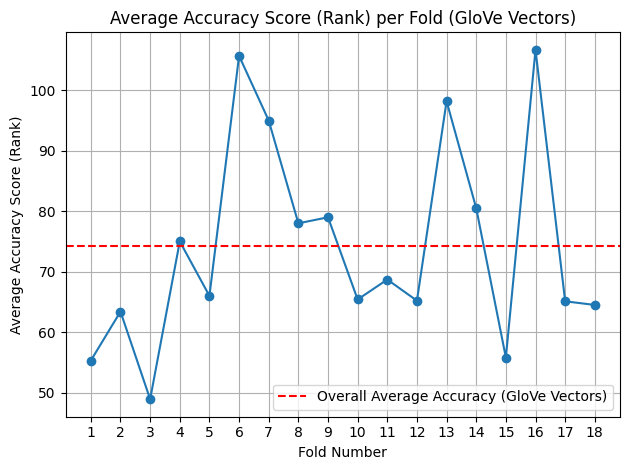

In [13]:
import matplotlib.pyplot as plt

glove_overall_average_accuracy = np.mean(glove_fold_accuracies)
print(f"Overall average accuracy score: {glove_overall_average_accuracy:.2f}")

plt.plot(range(1, n_folds + 1), glove_fold_accuracies, marker='o')
plt.axhline(y=glove_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (GloVe Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (GloVe Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('outputs/glove_accuracy_per_fold.png')
plt.show()

### Which concepts can be decoded with more or less success?

In [14]:
glove_concept_accuracies = dict(sorted(glove_concept_accuracies.items(), key=lambda item: item[1]))

In [15]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(glove_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: seafood, Concept Rank: 3.00
Concept: silly, Concept Rank: 5.00
Concept: stupid, Concept Rank: 5.00
Concept: prison, Concept Rank: 5.00
Concept: argumentatively, Concept Rank: 8.00
Concept: beer, Concept Rank: 8.00
Concept: useless, Concept Rank: 8.00
Concept: food, Concept Rank: 8.00
Concept: cook, Concept Rank: 8.00
Concept: ignorance, Concept Rank: 11.00


In [16]:
print("\nThe last 10 concepts are:")
for concept, concept_accuracy in list(glove_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")


The last 10 concepts are:
Concept: help, Concept Rank: 150.00
Concept: collection, Concept Rank: 153.00
Concept: sell, Concept Rank: 154.00
Concept: art, Concept Rank: 156.00
Concept: music, Concept Rank: 159.00
Concept: word, Concept Rank: 160.00
Concept: hair, Concept Rank: 165.00
Concept: building, Concept Rank: 167.00
Concept: quality, Concept Rank: 167.00
Concept: bed, Concept Rank: 175.00


### Using semantic vectors to decode brain activation (using Word2Vec)

In [17]:
# Now let's do the same for the word2vec vectors
word2vec_concept_accuracies, word2vec_fold_accuracies = test_accuracy(data_reduced, folds, word2vec_vectors)

Overall average accuracy score (Word2Vec): 74.66


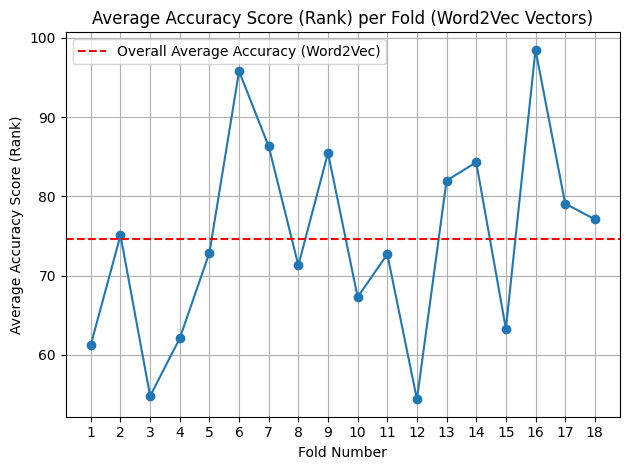

In [18]:
word2vec_overall_average_accuracy = np.mean(word2vec_fold_accuracies)
print(f"Overall average accuracy score (Word2Vec): {word2vec_overall_average_accuracy:.2f}")
plt.plot(range(1, n_folds + 1), word2vec_fold_accuracies, marker='o')
plt.axhline(y=word2vec_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Word2Vec)')
plt.title('Average Accuracy Score (Rank) per Fold (Word2Vec Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('outputs/word2vec_accuracy_per_fold.png')
plt.show()

### Which concepts can be decoded with more or less success?

In [19]:
word2vec_concept_accuracies = dict(sorted(word2vec_concept_accuracies.items(), key=lambda item: item[1]))

In [20]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(word2vec_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: garbage, Concept Rank: 3.00
Concept: food, Concept Rank: 4.00
Concept: seafood, Concept Rank: 4.00
Concept: silly, Concept Rank: 5.00
Concept: useless, Concept Rank: 7.00
Concept: ship, Concept Rank: 7.00
Concept: sew, Concept Rank: 8.00
Concept: beer, Concept Rank: 9.00
Concept: sad, Concept Rank: 9.00
Concept: prison, Concept Rank: 12.00


In [21]:
print("The last 10 concepts are:")
for concept, concept_accuracy in list(word2vec_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The last 10 concepts are:
Concept: residence, Concept Rank: 143.00
Concept: philosophy, Concept Rank: 144.00
Concept: art, Concept Rank: 144.00
Concept: personality, Concept Rank: 154.00
Concept: accomplished, Concept Rank: 161.00
Concept: ball, Concept Rank: 164.00
Concept: election, Concept Rank: 164.00
Concept: computer, Concept Rank: 166.00
Concept: music, Concept Rank: 167.00
Concept: doctor, Concept Rank: 167.00


### Part 1.3

In [22]:
exp2_fmri = exp2_data['Fmridata']
exp2_fmri_reduced = exp2_fmri[:, top_indices]

exp3_fmri = exp3_data['Fmridata']
exp3_fmri_reduced = exp3_fmri[:, top_indices]

In [23]:
print(exp2_fmri.shape)
print(exp2_fmri_reduced.shape)
print(exp3_fmri.shape)
print(exp3_fmri_reduced.shape)

(384, 185866)
(384, 185866)
(243, 185866)
(243, 185866)


In [24]:
# importing the vectors for the seconds and third experiments
exp2_vecs = read_matrix("data/vectors_384sentences.GV42B300.average.txt", sep=" ")
exp3_vecs = read_matrix("data/vectors_243sentences.GV42B300.average.txt", sep=" ")
# importing the corresponding sentences
exp2_sent = np.genfromtxt('data/stimuli_384sentences.txt', delimiter='\t', dtype=np.dtype('U'))
exp3_sent = np.genfromtxt('data/stimuli_243sentences.txt', delimiter='\t', dtype=np.dtype('U'))

In [25]:
print(exp2_vecs.shape)
print(exp3_vecs.shape)
print(exp2_sent.shape)
print(exp3_sent.shape)

(384, 300)
(243, 300)
(384,)
(243,)


In [26]:
def sentence_accuracy(train_data, train_vectors, sentence_data, sentence_vectors):
    sentence_accuracies = {}

    # Train the decoder
    decoder = learn_decoder(train_data, train_vectors)

    # Get predictions
    predictions = sentence_data @ decoder

    # Compute accuracy scores
    accuracy_scores = []
    # for each prediction, sorting all vectors by cosine similarity to the prediction
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        target = sentence_vectors[i]
        # Compute cosine similarity with all vectors
        similarities = np.dot(sentence_vectors, pred) / (np.linalg.norm(sentence_vectors, axis=1) * np.linalg.norm(pred))
        # Sort by similarity
        sorted_indices = np.argsort(similarities)[::-1]
        # Get the index of the target vector
        target_index = np.where(np.all(sentence_vectors[sorted_indices] == target, axis=1))[0][0] + 1
        accuracy_scores.append(target_index)
        # Store the accuracy score for the sentence
        sentence_accuracies[i] = target_index
    # Compute the average accuracy score
    avg_accuracy = np.mean(accuracy_scores)
    
    return sentence_accuracies, avg_accuracy
    

In [27]:
exp2_sentence_accuracies, exp2_avg_accuracy = sentence_accuracy(
    data_reduced, glove_vectors, exp2_fmri_reduced, exp2_vecs)

EXP2 Overall average accuracy score: 154.12 or 40.14% of the maximal rank


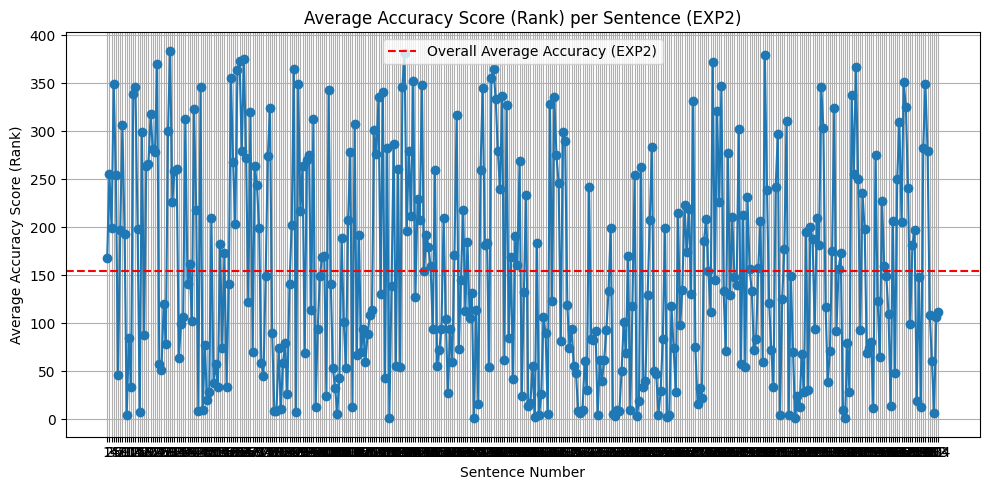

In [28]:
print(f"EXP2 Overall average accuracy score: {exp2_avg_accuracy:.2f} or {exp2_avg_accuracy / len(exp2_sent):.2%} of the maximal rank")
plt.figure(figsize=(10,5))
plt.plot(range(1, len(exp2_sentence_accuracies) + 1), list(exp2_sentence_accuracies.values()), marker='o')
plt.axhline(y=exp2_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (EXP2)')
plt.title('Average Accuracy Score (Rank) per Sentence (EXP2)')
plt.xlabel('Sentence Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, len(exp2_sentence_accuracies) + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('outputs/exp2_accuracy_per_sentence.png')
plt.show()

In [29]:
exp3_sentence_accuracies, exp3_avg_accuracy = sentence_accuracy(
    data_reduced, glove_vectors, exp3_fmri_reduced, exp3_vecs)

EXP3 Overall average accuracy score: 99.85 or 41.09% of the maximal rank


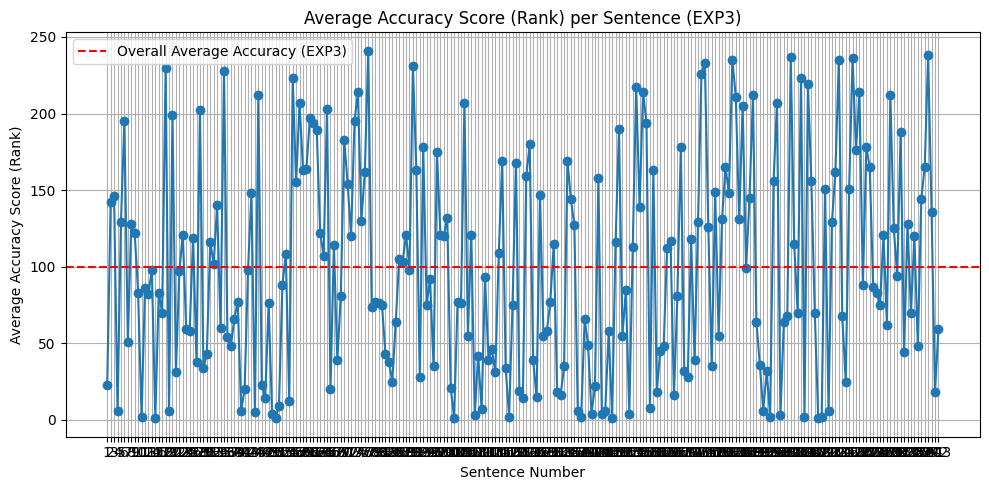

In [30]:
print(f"EXP3 Overall average accuracy score: {exp3_avg_accuracy:.2f} or {exp3_avg_accuracy / len(exp3_sent):.2%} of the maximal rank")
plt.figure(figsize=(10,5))
plt.plot(range(1, len(exp3_sentence_accuracies) + 1), list(exp3_sentence_accuracies.values()), marker='o')
plt.axhline(y=exp3_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (EXP3)')
plt.title('Average Accuracy Score (Rank) per Sentence (EXP3)')
plt.xlabel('Sentence Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, len(exp3_sentence_accuracies) + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('outputs/exp3_accuracy_per_sentence.png')
plt.show()

### Part 1.4

In [31]:
# for each sentence, we want to find the category of the sentence
exp2_sentence_to_category = {}
for sentence_id in exp2_sentence_accuracies.keys():
    exp2_sentence_to_category[sentence_id] = exp2_data['keyPassageCategory'].T[exp2_data['labelsPassageCategory'][exp2_data['labelsPassageForEachSentence'][sentence_id]-1]-1][0][0][0][0]

EXP2 Category Average Accuracies:
Category: fish, Average Accuracy: 70.50 or 18.36% of the maximal rank
Category: fruit, Average Accuracy: 77.06 or 20.07% of the maximal rank
Category: vegetable, Average Accuracy: 97.19 or 25.31% of the maximal rank
Category: drink_non_alcoholic, Average Accuracy: 99.62 or 25.94% of the maximal rank
Category: human, Average Accuracy: 114.38 or 29.79% of the maximal rank
Category: bird, Average Accuracy: 119.81 or 31.20% of the maximal rank
Category: disaster, Average Accuracy: 121.94 or 31.75% of the maximal rank
Category: kitchen_utensil, Average Accuracy: 131.25 or 34.18% of the maximal rank
Category: landscape, Average Accuracy: 134.00 or 34.90% of the maximal rank
Category: appliance, Average Accuracy: 134.06 or 34.91% of the maximal rank
Category: insect, Average Accuracy: 138.38 or 36.04% of the maximal rank
Category: body_part, Average Accuracy: 140.06 or 36.47% of the maximal rank
Category: clothing, Average Accuracy: 141.12 or 36.75% of the ma

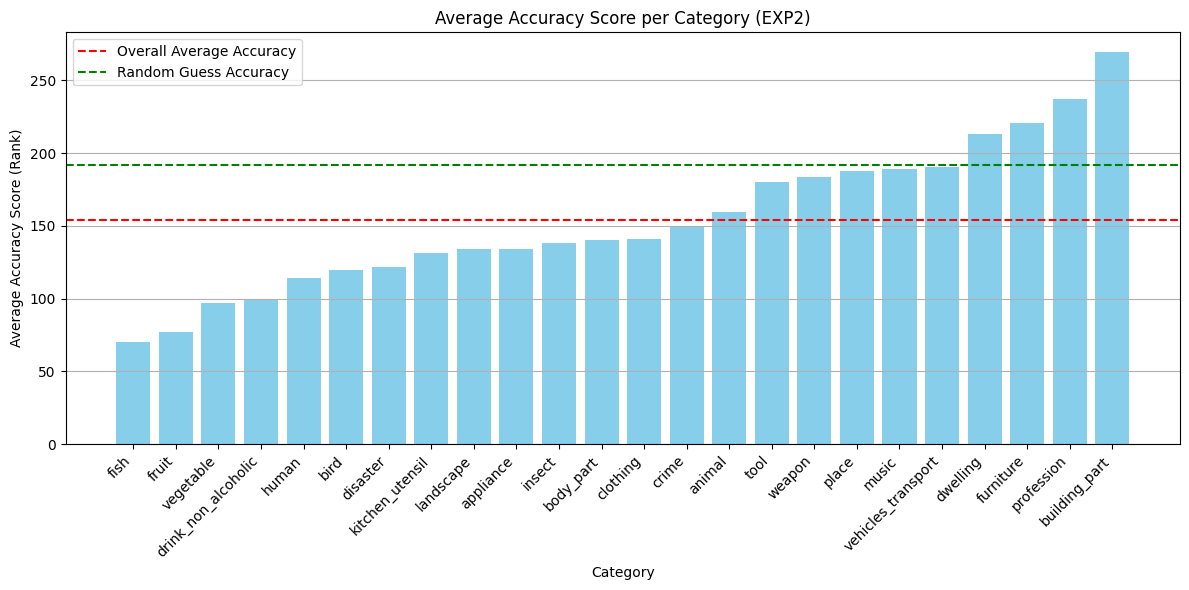

In [32]:
# for each category, we want to find the average accuracy of the sentences in that category
exp2_category_accuracies = {}
for sentence_id, category in exp2_sentence_to_category.items():
    if category not in exp2_category_accuracies:
        exp2_category_accuracies[category] = []
    exp2_category_accuracies[category].append(exp2_sentence_accuracies[sentence_id])
# Calculate the average accuracy for each category
exp2_category_avg_accuracies = {category: np.mean(accuracies) for category, accuracies in exp2_category_accuracies.items()}
# Print the average accuracies sorted by the accuracy value
exp2_category_avg_accuracies = dict(sorted(exp2_category_avg_accuracies.items(), key=lambda item: item[1], reverse=False))
print("EXP2 Category Average Accuracies:")
for category, avg_accuracy in exp2_category_avg_accuracies.items():
    print(f"Category: {category}, Average Accuracy: {avg_accuracy:.2f} or {avg_accuracy / len(exp2_sent):.2%} of the maximal rank")
# Plotting a bar chart of the average accuracies per category
categories = list(exp2_category_avg_accuracies.keys())
avg_accuracies = list(exp2_category_avg_accuracies.values())
plt.figure(figsize=(12, 6))
plt.bar(categories, avg_accuracies, color='skyblue')
# Adding horizontal line for overall average accuracy
overall_avg_accuracy = np.mean(list(exp2_category_avg_accuracies.values()))
plt.axhline(y=overall_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy')
# Adding horizontal line for the random guess accuracy
random_guess_accuracy = len(exp2_sent) / 2
plt.axhline(y=random_guess_accuracy, color='g', linestyle='--', label='Random Guess Accuracy')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Average Accuracy Score (Rank)')
plt.title('Average Accuracy Score per Category (EXP2)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('outputs/exp2_accuracy_per_category.png')
plt.show()

In [33]:
exp3_sentence_to_category = {}
for sentence_id in exp3_sentence_accuracies.keys():
    exp3_sentence_to_category[sentence_id] = exp3_data['keyPassageCategory'].T[exp3_data['labelsPassageCategory'][exp3_data['labelsPassageForEachSentence'][sentence_id]-1]-1][0][0][0][0]

EXP3 Category Average Accuracies:
Category: ice_cream, Average Accuracy: 59.00 or 24.28% of the maximal rank
Category: bone_fracture, Average Accuracy: 60.27 or 24.80% of the maximal rank
Category: taste, Average Accuracy: 64.78 or 26.66% of the maximal rank
Category: stress, Average Accuracy: 68.20 or 28.07% of the maximal rank
Category: tuxedo, Average Accuracy: 69.20 or 28.48% of the maximal rank
Category: opera, Average Accuracy: 74.00 or 30.45% of the maximal rank
Category: hurricane, Average Accuracy: 80.10 or 32.96% of the maximal rank
Category: blindness, Average Accuracy: 85.90 or 35.35% of the maximal rank
Category: dreams, Average Accuracy: 88.60 or 36.46% of the maximal rank
Category: gambling, Average Accuracy: 88.70 or 36.50% of the maximal rank
Category: beekeeping, Average Accuracy: 93.36 or 38.42% of the maximal rank
Category: polar_bear, Average Accuracy: 95.40 or 39.26% of the maximal rank
Category: castle, Average Accuracy: 95.90 or 39.47% of the maximal rank
Catego

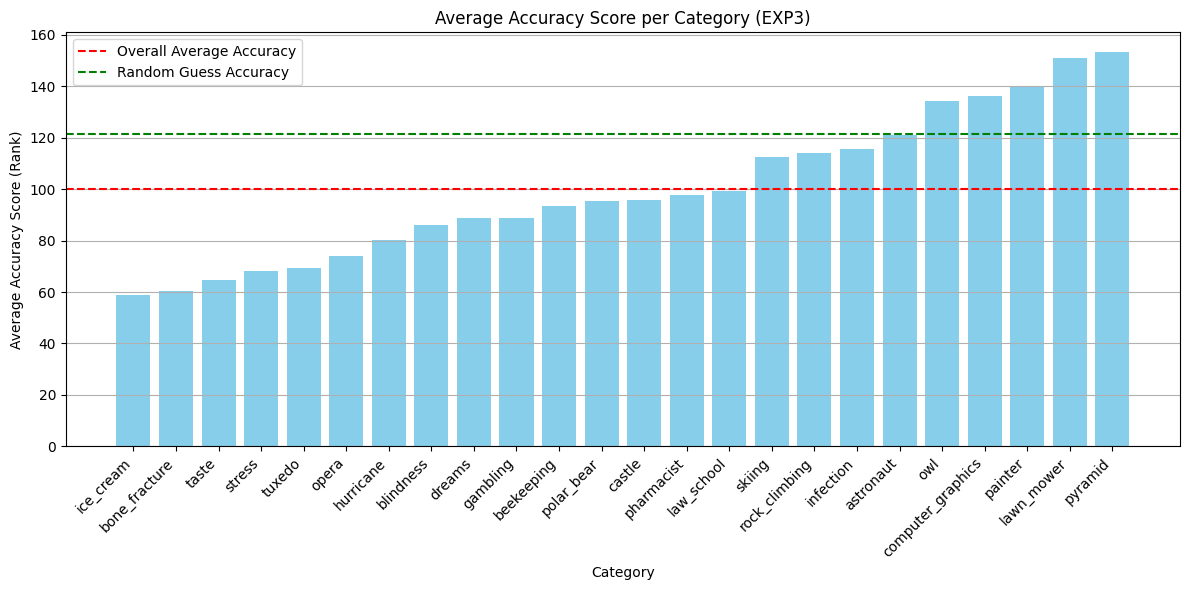

In [34]:
# for each category, we want to find the average accuracy of the sentences in that category
exp3_category_accuracies = {}
for sentence_id, category in exp3_sentence_to_category.items():
    if category not in exp3_category_accuracies:
        exp3_category_accuracies[category] = []
    exp3_category_accuracies[category].append(exp3_sentence_accuracies[sentence_id])
# Calculate the average accuracy for each category
exp3_category_avg_accuracies = {category: np.mean(accuracies) for category, accuracies in exp3_category_accuracies.items()}
# Print the average accuracies sorted by the accuracy value
exp3_category_avg_accuracies = dict(sorted(exp3_category_avg_accuracies.items(), key=lambda item: item[1], reverse=False))
print("EXP3 Category Average Accuracies:")
for category, avg_accuracy in exp3_category_avg_accuracies.items():
    print(f"Category: {category}, Average Accuracy: {avg_accuracy:.2f} or {avg_accuracy / len(exp3_sent):.2%} of the maximal rank")
# Plotting a bar chart of the average accuracies per category
categories = list(exp3_category_avg_accuracies.keys())
avg_accuracies = list(exp3_category_avg_accuracies.values())
plt.figure(figsize=(12, 6))
plt.bar(categories, avg_accuracies, color='skyblue')
# Adding horizontal line for overall average accuracy
overall_avg_accuracy = np.mean(list(exp3_category_avg_accuracies.values()))
plt.axhline(y=overall_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy')
# Adding horizontal line for the random guess accuracy
random_guess_accuracy = len(exp3_sent) / 2
plt.axhline(y=random_guess_accuracy, color='g', linestyle='--', label='Random Guess Accuracy')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Average Accuracy Score (Rank)')
plt.title('Average Accuracy Score per Category (EXP3)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('outputs/exp3_accuracy_per_category.png')
plt.show()

# Task 2: Sentence representations

In [35]:
import torch
from transformers import BertTokenizer, BertModel
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [36]:
# We will use sentences from experiment 2 to train and test the decoder
exp2_bert_vecs = np.zeros((len(exp2_sent), 768), dtype=np.float32)
for i, sentence in enumerate(exp2_sent):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        exp2_bert_vecs[i] = last_hidden_state.mean(dim=1).squeeze().numpy()

In [37]:
# splitting the data into 18 folds
np.random.seed(3)

n_folds = 18
n_samples = exp2_fmri_reduced.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)
exp2_folds = np.array_split(indices, n_folds)
print(exp2_folds)

[array([345,  16, 307, 364, 199, 305, 280, 323, 278, 218,  73, 224, 271,
       191, 237, 241,  37,  55, 374, 262,  56, 115]), array([ 15,  40, 189, 214, 332, 102, 301,  24, 201, 228, 348, 321,  81,
       344, 330, 210, 134, 303,  31,  83, 144, 146]), array([261,  66, 142,  61, 243,  98, 313, 128, 107,  27, 306, 105, 353,
       114, 204, 272, 276,  84, 299, 375, 137, 325]), array([250, 379, 127, 130,  82,  53, 333, 239,  10, 126,  74, 188, 194,
       265, 234,  23, 266, 112, 380, 294, 190, 342]), array([ 59,  50,  38, 366, 287, 166,  80, 309, 381,   5,  75,  14,  47,
        46, 123, 154,  79, 193,  30, 376, 367, 329]), array([101, 157, 155,  25, 244,  67, 227, 231, 229,  65, 245, 336, 312,
        70, 269, 103, 310, 136, 185, 370,  68, 153]), array([ 77, 383, 197,  58, 125,  42,   4, 121, 368, 259, 248, 109, 118,
       220,   6, 236, 217, 159, 186, 211, 209]), array([180,   3, 338, 122,  78,  64,  18, 151, 372,  43, 286, 163, 365,
       140, 361, 377, 296, 288, 238, 168, 317]), a

In [38]:
def fold_sentence_accuracy(data, folds, embedding_vectors):
    sentence_accuracies = {}
    fold_accuracies = []

    for test_id, test_fold in enumerate(folds):
        train_folds = [fold for i, fold in enumerate(folds) if i != test_id]
        train_indices = np.concatenate(train_folds)
        test_indices = test_fold

        train_data = data[train_indices]
        test_data = data[test_indices]

        train_vectors = embedding_vectors[train_indices]
        test_vectors = embedding_vectors[test_indices]

        # Train the decoder
        decoder = learn_decoder(train_data, train_vectors)

        # Get predictions
        predictions = test_data @ decoder

        # Compute accuracy scores
        accuracy_scores = []
        # for each prediction, sorting all vectors by cosine similarity to the prediction
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = test_vectors[i]
            # Compute cosine similarity with all vectors
            similarities = np.dot(embedding_vectors, pred) / (np.linalg.norm(embedding_vectors, axis=1) * np.linalg.norm(pred))
            # Sort by similarity
            sorted_indices = np.argsort(similarities)[::-1]
            # Get the index of the target vector
            target_index = np.where(np.all(embedding_vectors[sorted_indices] == target, axis=1))[0][0] + 1
            accuracy_scores.append(target_index)
            # Store the accuracy score for the concept
            sentence_id = test_indices[i]
            sentence_accuracies[sentence_id] = target_index
        # Compute the average accuracy score
        avg_accuracy = np.mean(accuracy_scores)
        fold_accuracies.append(avg_accuracy)
    
    return sentence_accuracies, fold_accuracies

In [39]:
# testing the accuracy of the decoder with the original vectors
exp2_org_sentence_accuracies, exp2_org_fold_accuracies = fold_sentence_accuracy(
    exp2_fmri_reduced, exp2_folds, exp2_vecs)
exp2_org_overall_average_accuracy = np.mean(exp2_org_fold_accuracies)

EXP2 Overall average accuracy score (original vectors): 33.96 or 8.84% of the maximal rank


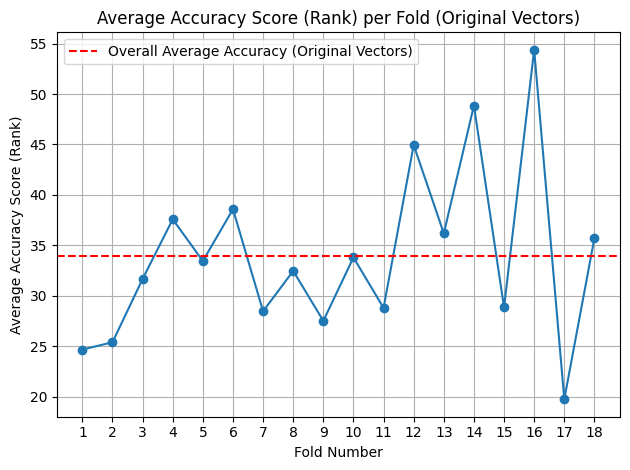

In [40]:
print(f"EXP2 Overall average accuracy score (original vectors): {exp2_org_overall_average_accuracy:.2f} or {exp2_org_overall_average_accuracy / len(exp2_sent):.2%} of the maximal rank")
plt.plot(range(1, n_folds + 1), exp2_org_fold_accuracies, marker='o')
plt.axhline(y=exp2_org_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Original Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (Original Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('outputs/exp2_accuracy_per_fold_glove.png')
plt.show()

In [41]:
# testing the accuracy of the decoder with BERT vectors
exp2_bert_sentence_accuracies, exp2_bert_fold_accuracies = fold_sentence_accuracy(
    exp2_fmri_reduced, exp2_folds, exp2_bert_vecs)
exp2_bert_overall_average_accuracy = np.mean(exp2_bert_fold_accuracies)

EXP2 Overall average accuracy score (BERT vectors): 27.00 or 7.03% of the maximal rank


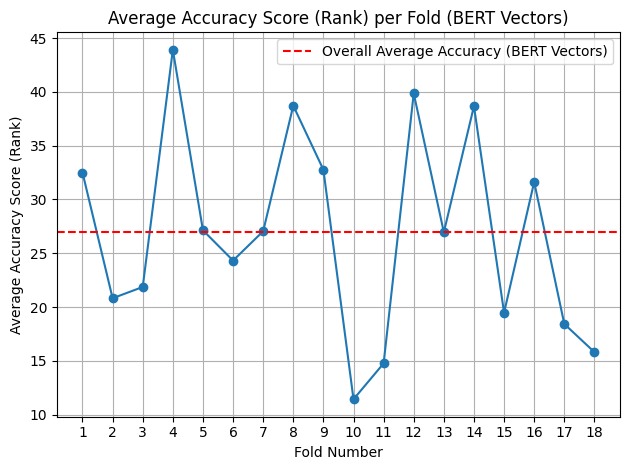

In [42]:
print(f"EXP2 Overall average accuracy score (BERT vectors): {exp2_bert_overall_average_accuracy:.2f} or {exp2_bert_overall_average_accuracy / len(exp2_sent):.2%} of the maximal rank")
plt.plot(range(1, n_folds + 1), exp2_bert_fold_accuracies, marker='o')
plt.axhline(y=exp2_bert_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (BERT Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (BERT Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('outputs/exp2_accuracy_per_fold_bert.png')
plt.show()

# Task 3: Brain encoder model

In [57]:
def test_voxel(data, vectors, voxel):
    voxel_data = data[:, voxel]
    # Fit a linear regression model
    model = sklearn.linear_model.LinearRegression()
    model.fit(vectors, voxel_data)
    
    # Predict the voxel data
    predictions = model.predict(vectors)
    
    # Calculate R^2 value
    r2 = model.score(vectors, voxel_data)
    
    # Calculate p-value using Pearson correlation
    # if the predictions are constant, we cannot compute correlation
    if np.std(predictions) < 1e-9:
        return 0.0, 1.0
    corr, p_value = pearsonr(predictions.flatten(), voxel_data.flatten())
    
    return r2, p_value

# For each voxel in the dataset corresponding to experiment 2,
# we use the original (and later BERT) vectors, to build a linear regression model for the prediction
# of that voxel's activity.
# For each voxel, we report the R^2 value of the model and the significance of the model.
def voxel_regression(data, vectors, n_jobs: int = -1, print_progress: bool = True):
    """ Given a CxV matrix of C concepts and V voxel activations,
    return a V-dimensional vector of R^2 values for each voxel
    by performing linear regression for each voxel.
    """
    n_voxels = data.shape[1]
    r2_values = np.zeros(n_voxels)
    p_values = np.zeros(n_voxels)

    voxel_tasks = [
        delayed(test_voxel)(
            data, 
            vectors, 
            voxel
        ) for voxel in range(n_voxels)
    ]

    voxel_results = Parallel(n_jobs=n_jobs)(
        tqdm(voxel_tasks, 
             desc="Processing Voxels", 
             total=n_voxels, 
             unit="voxel", 
             disable=not print_progress)
    )

    for voxel, (r2, p_value) in enumerate(voxel_results):
        r2_values[voxel] = r2
        p_values[voxel] = p_value

    return r2_values, p_values

In [59]:
exp2_org_r2_values, exp2_org_p_values = voxel_regression(exp2_fmri_reduced, exp2_vecs, n_jobs=6, print_progress=True)

Processing Voxels: 100%|██████████| 185866/185866 [28:20<00:00, 109.27voxel/s]


In [60]:
# saving the results to avoid recomputing them
with open('data/exp2_org_r2_values.pkl', 'wb') as f:
    pickle.dump(exp2_org_r2_values, f)
with open('data/exp2_org_p_values.pkl', 'wb') as f:
    pickle.dump(exp2_org_p_values, f)

In [43]:
# if we need to load the results later
with open('data/exp2_org_r2_values.pkl', 'rb') as f:
    exp2_org_r2_values = pickle.load(f)
with open('data/exp2_org_p_values.pkl', 'rb') as f:
    exp2_org_p_values = pickle.load(f)

Number of significant voxels (original vectors): 185734 out of 185866 or 99.93% of all voxels
Average R^2 value for significant voxels: 0.8028
Average R^2 value for non-significant voxels: 0.0000
Average R^2 value for all voxels: 0.8023


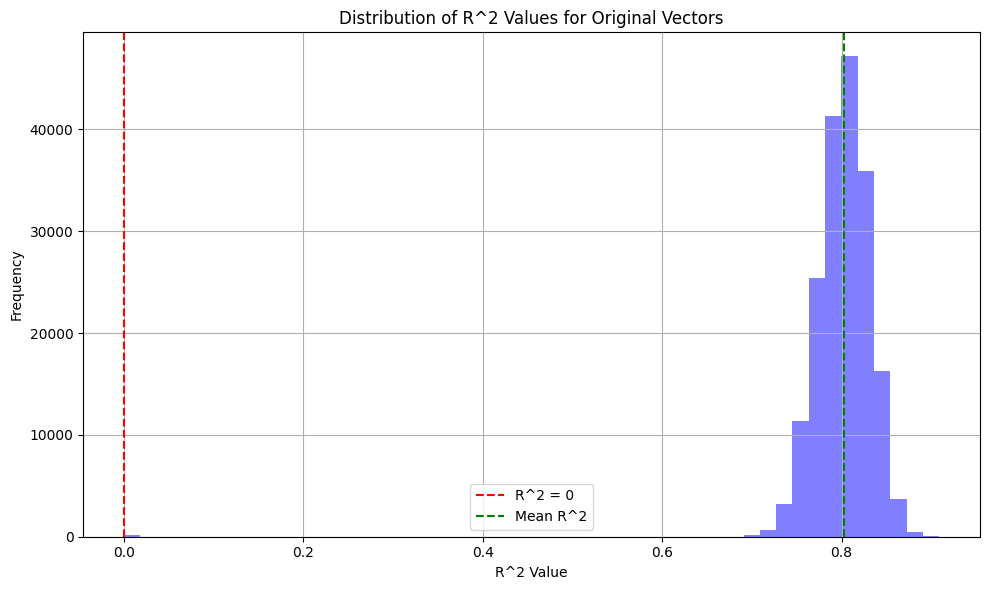

In [44]:
# finding how many voxels have a significant R^2 value
significant_voxels = np.sum(exp2_org_p_values < 0.05)
print(f"Number of significant voxels (original vectors): {significant_voxels} out of {exp2_fmri_reduced.shape[1]} or {significant_voxels / exp2_fmri_reduced.shape[1]:.2%} of all voxels")
print(f"Average R^2 value for significant voxels: {np.mean(exp2_org_r2_values[exp2_org_p_values < 0.05]):.4f}")
print(f"Average R^2 value for non-significant voxels: {np.mean(exp2_org_r2_values[exp2_org_p_values >= 0.05]):.4f}")
print(f"Average R^2 value for all voxels: {np.mean(exp2_org_r2_values):.4f}")
# plotting the distribution of R^2 values
plt.figure(figsize=(10, 6))
plt.hist(exp2_org_r2_values, bins=50, color='blue', alpha=0.5)
plt.title('Distribution of R^2 Values for Original Vectors')
plt.xlabel('R^2 Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='R^2 = 0')
plt.axvline(x=np.mean(exp2_org_r2_values), color='green', linestyle='--', label='Mean R^2')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('outputs/exp2_r2_distribution_glove.png')
plt.show()

In [67]:
# Now we do the same for the BERT vectors
exp2_bert_r2_values, exp2_bert_p_values = voxel_regression(exp2_fmri_reduced, exp2_bert_vecs, n_jobs=6, print_progress=True)

Processing Voxels: 100%|██████████| 185866/185866 [49:15<00:00, 62.90voxel/s] 


In [68]:
# Saving the results to avoid recomputing them
with open('data/exp2_bert_r2_values.pkl', 'wb') as f:
    pickle.dump(exp2_bert_r2_values, f)
with open('data/exp2_bert_p_values.pkl', 'wb') as f:
    pickle.dump(exp2_bert_p_values, f)

In [45]:
# In case we need to load the results later
with open('data/exp2_bert_r2_values.pkl', 'rb') as f:
    exp2_bert_r2_values = pickle.load(f)
with open('data/exp2_bert_p_values.pkl', 'rb') as f:
    exp2_bert_p_values = pickle.load(f)

Number of significant voxels (BERT vectors): 185734 out of 185866 or 99.93% of all voxels
Average R^2 value for significant voxels (BERT vectors): 1.0000
Average R^2 value for non-significant voxels (BERT vectors): 0.0000
Average R^2 value for all voxels (BERT vectors): 0.9993


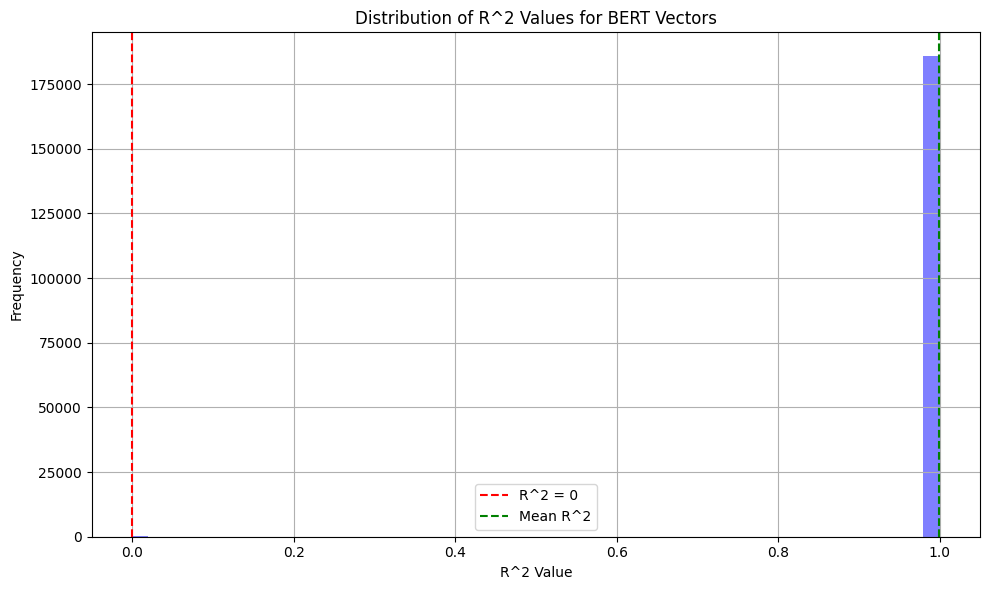

In [46]:
# finding how many voxels have a significant R^2 value
significant_voxels_bert = np.sum(exp2_bert_p_values < 0.05)
print(f"Number of significant voxels (BERT vectors): {significant_voxels_bert} out of {exp2_fmri_reduced.shape[1]} or {significant_voxels_bert / exp2_fmri_reduced.shape[1]:.2%} of all voxels")
print(f"Average R^2 value for significant voxels (BERT vectors): {np.mean(exp2_bert_r2_values[exp2_bert_p_values < 0.05]):.4f}")
print(f"Average R^2 value for non-significant voxels (BERT vectors): {np.mean(exp2_bert_r2_values[exp2_bert_p_values >= 0.05]):.4f}")
print(f"Average R^2 value for all voxels (BERT vectors): {np.mean(exp2_bert_r2_values):.4f}")
# plotting the distribution of R^2 values
plt.figure(figsize=(10, 6))
plt.hist(exp2_bert_r2_values, bins=50, color='blue', alpha=0.5)
plt.title('Distribution of R^2 Values for BERT Vectors')
plt.xlabel('R^2 Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='R^2 = 0')
plt.axvline(x=np.mean(exp2_bert_r2_values), color='green', linestyle='--', label='Mean R^2')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('outputs/exp2_r2_distribution_bert.png')
plt.show()